In [68]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [69]:
input_size = 784
hidden_size = 2048
num_hidden_layers=3
num_classes = 10
num_epochs = 50
batch_size = 20
learning_rate = 0.1

M_train = 100
M_test = 1000

In [70]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layer):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_hidden_layer-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [71]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='RandomData', train=True, transform=transforms.ToTensor(), 
                                           target_transform=lambda y: torch.randint(0, 5, (1,)).item() if y<=4 else y, 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='RandomData', train=False, transform=transforms.ToTensor(),
                                          target_transform=lambda y: torch.randint(0, 5, (1,)).item() if y<=4 else y)

train_index=list(range(M_train))
test_index=list(range(M_test))

subset_train_dataset=Subset(train_dataset, train_index)
subset_test_dataset=Subset(test_dataset, test_index)

# Data loader
random_train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

random_test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [72]:
model = NeuralNet(input_size, hidden_size, num_classes, num_hidden_layers)
ReLU_glorot_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate) 

def train_epoch(coherence=False):
    if coherence:
        no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
        expected_gradient=np.zeros(no_parameters)
        expected_dot=0
        counter=0

        for images, labels in random_train_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            batch_gradient=[]
            batch_gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            batch_gradient+=model.input_layer.bias.grad.tolist()
            batch_gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            batch_gradient+=model.output_layer.bias.grad.tolist()
            batch_gradient=np.array(batch_gradient)
            expected_gradient+=batch_gradient
            expected_dot+=dot(batch_gradient,batch_gradient)
            counter+=1

            optimizer.step()

        expected_dot=expected_dot/counter
        expected_gradient=expected_gradient/counter

        batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
        k=len(random_train_loader)
        perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
        return loss.item(), perexample_coherence*M_train
    else:
        for images, labels in random_train_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss.item(),0


def accuracy(model,loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(model,loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

random_train_loss=[]
random_train_accuracy=[]
random_test_loss=[]
random_test_accuracy=[]
random_alpha_list=[]

for epoch in range(num_epochs):
    random_trainloss, random_alpha = train_epoch()
    random_train_loss.append(random_trainloss)
    random_alpha_list.append(random_alpha)
    random_train_accuracy.append(accuracy(model,random_train_loader))
    random_test_loss.append(loss(model,random_test_loader))
    random_test_accuracy.append(accuracy(model,random_test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,random_train_loss[-1],random_test_loss[-1],random_train_accuracy[-1],random_test_accuracy[-1],random_alpha_list[-1]))

Epoch: 1 TrainLoss: 2.270 TestLoss: 2.235 TrainAccuracy: 0.330 TestAccuracy: 0.127 Coherence: 0.000
Epoch: 2 TrainLoss: 1.945 TestLoss: 2.157 TrainAccuracy: 0.450 TestAccuracy: 0.253 Coherence: 0.000
Epoch: 3 TrainLoss: 1.453 TestLoss: 2.088 TrainAccuracy: 0.480 TestAccuracy: 0.280 Coherence: 0.000
Epoch: 4 TrainLoss: 1.817 TestLoss: 2.010 TrainAccuracy: 0.590 TestAccuracy: 0.288 Coherence: 0.000
Epoch: 5 TrainLoss: 1.461 TestLoss: 2.049 TrainAccuracy: 0.510 TestAccuracy: 0.257 Coherence: 0.000
Epoch: 6 TrainLoss: 1.202 TestLoss: 2.057 TrainAccuracy: 0.540 TestAccuracy: 0.278 Coherence: 0.000
Epoch: 7 TrainLoss: 1.306 TestLoss: 1.999 TrainAccuracy: 0.540 TestAccuracy: 0.287 Coherence: 0.000
Epoch: 8 TrainLoss: 1.313 TestLoss: 1.934 TrainAccuracy: 0.560 TestAccuracy: 0.282 Coherence: 0.000
Epoch: 9 TrainLoss: 0.906 TestLoss: 2.032 TrainAccuracy: 0.540 TestAccuracy: 0.264 Coherence: 0.000
Epoch: 10 TrainLoss: 0.660 TestLoss: 1.915 TrainAccuracy: 0.530 TestAccuracy: 0.314 Coherence: 0.000

KeyboardInterrupt: 

Text(0.5, 1.0, 'Coherence Against Loss')

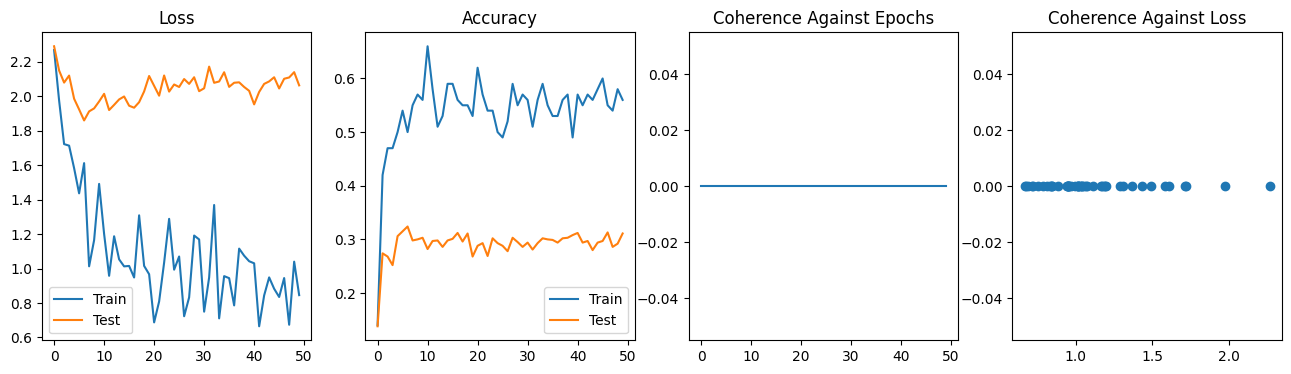

In [ ]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), random_alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].scatter(np.flip(random_train_loss), random_alpha_list)
axs[3].set_title('Coherence Against Loss')

Here approximately $50$% of the data is clean and the rest is randomized. Hence, we see that accuracy is much lower than the clean case.

NameError: name 'train_loss' is not defined

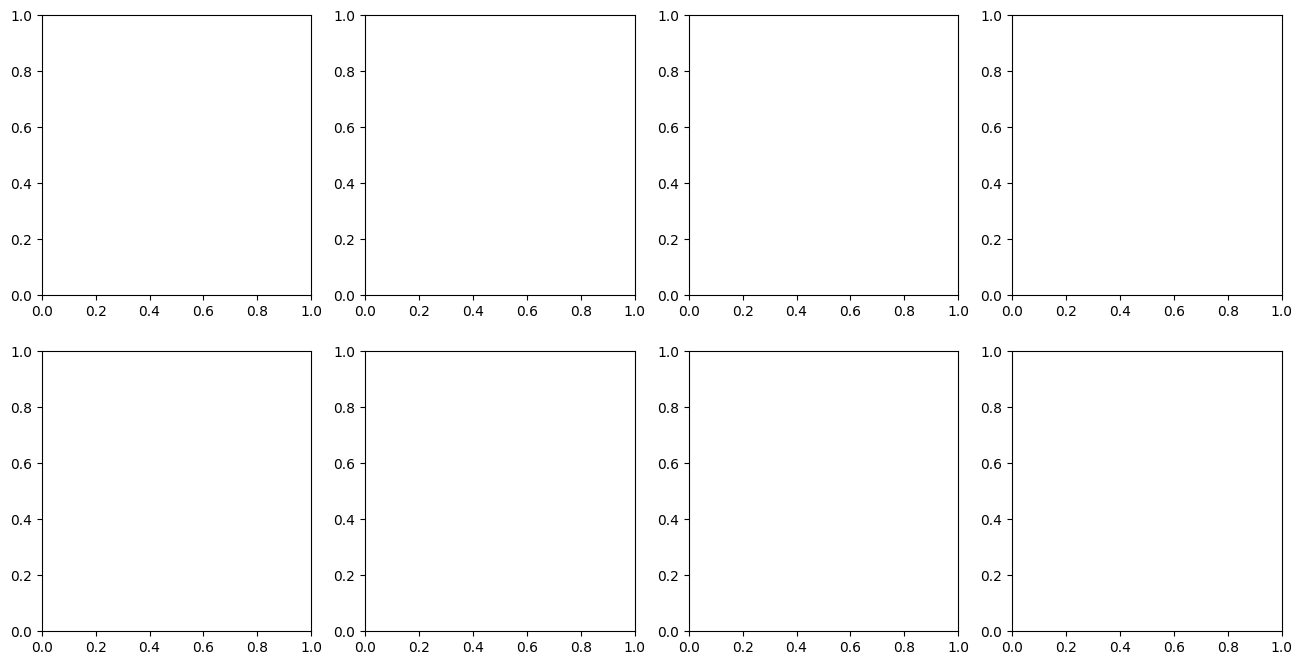

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(16,8))

axs[0,0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0,0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0,0].set_ylim((0,max([max(train_loss),max(test_loss)])*1.05))
axs[0,0].set_title('Loss')
axs[0,0].legend()
axs[0,1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[0,1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[0,1].set_ylim((0,1.05))
axs[0,1].set_title('Accuracy')
axs[0,1].legend()
axs[0,2].plot(np.arange(num_epochs), alpha_list)
axs[0,2].set_title('Coherence Against Epochs')
axs[0,2].set_ylim((0,max(alpha_list)*1.1))
axs[0,3].plot(np.flip(train_loss), alpha_list,'o', markersize=0.8)
axs[0,3].set_title('Coherence Against Loss')

axs[1,0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[1,0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[1,0].set_ylim((0,max([max(random_train_loss),max(random_test_loss)])*1.05))
axs[1,0].set_title('Loss')
axs[1,0].legend()
axs[1,1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1,1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1,1].set_ylim((0,1.05))
axs[1,1].set_title('Accuracy')
axs[1,1].legend()
axs[1,2].plot(np.arange(num_epochs), random_alpha_list)
axs[1,2].set_title('Coherence Against Epochs')
axs[1,2].set_ylim((0,max(random_alpha_list)*1.1))
axs[1,3].plot(np.flip(random_train_loss), random_alpha_list,'o', markersize=0.8)
axs[1,3].set_title('Coherence Against Loss')

plt.savefig('plots/coherence_MNIST.png')